<a href="https://colab.research.google.com/github/yukyeongmin/NenepBigData/blob/master/Modeling/GloVeLSTMsimple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#구글 드라이브와 코랩 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%matplotlib inline
import copy
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

SEED = 123
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data, datasets
from torchtext.vocab import GloVe
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from gensim.models.word2vec import Word2Vec

In [9]:
dataset = pd.read_csv("/content/drive/MyDrive/lemmatizing.csv",index_col = 0)
dataset.head()

,review,label
0,act end atmosphere despair mixed happy moment ...,3
1,honest go watch film negative mind anyway hear...,7
2,year gibson braveheart scottish movie false ex...,8
3,change story dad really thing movie go decent ...,1
4,movie potential top line intelligent science f...,7


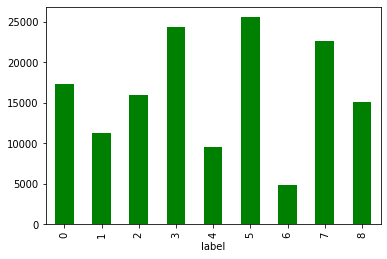

In [10]:
dataset.groupby('label').size().plot(kind='bar', color='g')


# **Split Train and Test data**

In [11]:
split = StratifiedShuffleSplit(n_splits=1,test_size = 0.3, random_state=77)
for train_idx, test_idx in split.split(dataset, dataset["label"]):
  trainset = dataset.loc[train_idx]
  testset = dataset.loc[test_idx]

In [12]:
trainset = trainset.reset_index(drop = True)
testset = testset.reset_index(drop = True)

trainset.to_csv("/content/drive/MyDrive/trainset.csv",index = False)
testset.to_csv("/content/drive/MyDrive/testset.csv", index = False)

In [13]:
TEXT = data.Field(sequential = True,
                  use_vocab = True,
                  tokenize = "spacy",
                  batch_first = True)
LABEL = data.Field(sequential = False,
                   use_vocab = False,
                   batch_first = False,
                   is_target = True)
fields = [('review', TEXT),('label',LABEL)]
train_data, test_data = data.TabularDataset.splits(path = "/content/drive/MyDrive/",
                                     train = 'trainset.csv',
                                     test = 'testset.csv', 
                                     format = "csv", fields = fields,
                                     skip_header = True)

In [ ]:
print(vars(train_data[0]))

{'review': ['keep', 'hop', 'wake', 'see', 'one', 'top', 'three', 'movie', 'time', 'dream', 'dupe', 'payola', 'ridden', 'viral', 'fest', 'rating', 'entertainment', 'net', 'become', 'example', 'intelligent', 'comic', 'book', 'treatment', 'film', 'example', 'intelligent', 'film', 'dream', 'neither', 'currently', 'rat', 'mile', 'shill', 'figure', 'conceptual', 'shortcoming', 'good', 'movie', 'technical', 'perspective', 'overact', 'entire', 'cast', 'effort', 'bring', 'life', 'snooze', 'even', 'high', 'dollar', 'action', 'scene', 'cgi', 'liven', 'comic', 'relief', 'none', 'whatsoever', 'allay', 'squirm', 'theater', 'seat', 'wonder', 'ever', 'love', 'interest', 'subplot', 'head', 'scratchingly', 'extraneous', 'might', 'interest', 'corporate', 'espionage', 'thriller', 'carry', 'movie', 'save', 'life', 'fact', 'entire', 'cast', 'miscast', 'disagree', 'dream', 'cast', 'lead', 'tell', 'wrong'], 'label': '7'}


# **Use Pre-trained GloVe word embedding**

In [ ]:
TEXT.build_vocab(train_data, vectors = GloVe(name = '6B',dim = 300),
                 max_size = 50000, min_freq = 4)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                          
100%|█████████▉| 399182/400000 [00:41<00:00, 9556.53it/s]

In [ ]:
vocab_size = len(TEXT.vocab)
n_classes = 9
print("단어 집합의 크기 : {}".format(vocab_size))
print("클래스의 개수 : {}".format(n_classes))

단어 집합의 크기 : 25039
클래스의 개수 : 9


In [ ]:
print("임베딩 벡터의 개수와 차원 : {}".format(TEXT.vocab.vectors.shape))

임베딩 벡터의 개수와 차원 : torch.Size([25039, 300])


(array([     0.,  50000., 100000., 150000., 200000., 250000.]),
 <a list of 6 Text major ticklabel objects>)

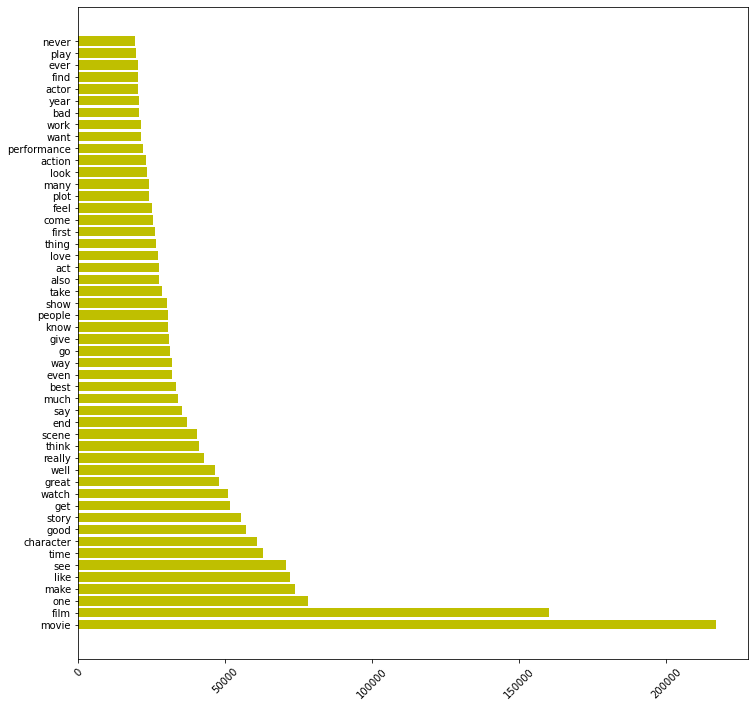

In [ ]:
#print(TEXT.vocab.stoi)
a=TEXT.vocab.freqs.most_common(50)
index=list()
value=list()
for i in a:
  index.append(i[0])
  value.append(i[1])
fig = plt.figure(figsize=(12, 12))
plt.barh(index, value, color='y')
plt.xticks(rotation=45)


# **Split Train and Val Data**

([<matplotlib.patches.Wedge at 0x7f4253952080>,
 [Text(-0.21548852023467327, 1.1296303367239529, 'train'),
  Text(-0.7872291576900415, -0.8383139348016517, 'validation'),
  Text(0.6759530924008326, -0.9303695055588138, 'test')],
 [Text(-0.12179785926307618, 0.6384867120613645, '56.0%'),
  Text(-0.4449556108682843, -0.47382961532267265, '14.0%'),
  Text(0.3820604435309054, -0.5258610248810686, '30.0%')])

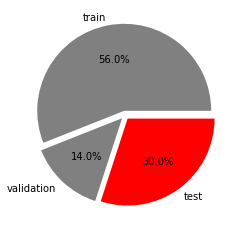

In [ ]:
trainset, valset = train_data.split(split_ratio=0.8)
ratio=[len(trainset),len(valset), len(test_data)]
labels=['train', 'validation','test']
explode = [0.05, 0.05, 0.05]
plt.pie(ratio, labels=labels,autopct='%0.1f%%', colors=["gray", "gray", "red"], explode=explode )

In [ ]:
train_iter, val_iter, test_iter = data.BucketIterator.splits((trainset,valset,test_data), batch_size = 64, shuffle = True, sort = False)

In [ ]:
print('훈련 데이터의 미니 배치의 개수 : {}'.format(len(train_iter)))
print('테스트 데이터의 미니 배치의 개수 : {}'.format(len(test_iter)))
print('검증 데이터의 미니 배치의 개수 : {}'.format(len(val_iter)))

훈련 데이터의 미니 배치의 개수 : 1284
테스트 데이터의 미니 배치의 개수 : 688
검증 데이터의 미니 배치의 개수 : 321


In [ ]:
# batch = next(iter(test_iter))
# batch

In [ ]:
# batch = next(iter(val_iter))
# batch

In [ ]:
# batch = next(iter(train_iter))
# batch

In [ ]:
is_cuda = torch.cuda.is_available()
print("Cuda Status on system is {}".format(is_cuda))

Cuda Status on system is True


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Construct Stacked LSTM(2Layer)**

In [ ]:
#RNN 모델
class RNN(nn.Module):
  def __init__(self, embedding_vectors, embedding_size, hidden_size):
    super().__init__()
    self.embedding_vectors = embedding_vectors
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size

    self.embedding_layer = nn.Embedding.from_pretrained(embedding_vectors,freeze = False)
    # LSTM Layer
    self.LSTM = nn.Sequential(
        nn.LSTM(
        input_size = embedding_size,
        hidden_size = hidden_size,
        num_layers = 2,                       # stacked LSTM 2layers
        batch_first = True),
    )
    # fully-connected Layer
    self.fc1 = nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Linear(hidden_size, 9)
    )
    
  def forward(self, x):
    y = self.embedding_layer(x)
    weight = self._init_state(batch_size = x.size(0))
    y, hidden = self.LSTM(y)
    h_t = y[:,-1,:]
    y = self.fc1(h_t)
    y = self.fc2(y)
    return y

  def _init_state(self, batch_size=1):
    weight = next(self.parameters()).data
    return weight.new(batch_size, self.hidden_size).zero_()

# **Training sequence(epoch = 10, LR = 0.003, min_freq = 4)**

In [ ]:
epoch = 10
learning_rate = 0.003
# LSTM using Pytorch
def LSTM_Train(train_loader, test_loader, epoch, learning_rate, no_cuda = False):
  use_cuda = not no_cuda and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  Model = RNN(TEXT.vocab.vectors,300,300).to(device)
  optimizer = torch.optim.AdamW(Model.parameters(), lr = learning_rate)
  train_L_iters = []
  train_acc_iters = []
  test_L_iters = []
  test_acc_iters = []
  best_test_loss = 100000
  for i in range(1,epoch+1):
    # Train mode
    train_loss = 0
    train_correct = 0
    Model.train()
    for batch_idx, batch in enumerate(train_loader):
      # data와 target을 gpu를 사용할 수 있게 매핑
      data, target = batch.review.to(device), batch.label.to(device)
      # backward하는 과정에서 기존의 gradient값에 새로운 gradient 값을
      # 더해주기때문에 grad값을 매 backward마다 0으로 초기화해줘야 올바른 학습이 가능
      optimizer.zero_grad()
      # 순전파
      output = Model(data)
      # reduction = (default) "mean"
      loss = F.cross_entropy(output,target)
      train_loss += F.cross_entropy(output,target,reduction = 'sum').item()
      pred = output.argmax(dim = 1, keepdim = True)
      train_correct += pred.eq(target.view_as(pred)).sum().item()
      # 역전파
      loss.backward()
      optimizer.step()
    # 에포크별 평균 트레인 로스 계산
    train_loss /= len(train_loader.dataset)
    train_L_iters.append(train_loss)
    # 에포크별 평균 정확도 계산
    accuracy =  100 * train_correct / len(train_loader.dataset)
    train_acc_iters.append(accuracy)    
    # torch.no_grad() 테스트 할 때, 위에서 계산한 grad를 더이상 업데이트 하지 않음.
    with torch.no_grad():
      Model.eval()
      test_loss = 0
      test_correct = 0
      for batch in test_loader:
        data, target = batch.review.to(device), batch.label.to(device)
        output = Model(data)
        test_loss += F.cross_entropy(output, target, reduction = 'sum').item()
        pred = output.argmax(dim = 1, keepdim = True)
        test_correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_L_iters.append(test_loss)
    accuracy = 100 * test_correct / len(test_loader.dataset)
    test_acc_iters.append(accuracy)
    if i % 1 == 0:
      print("progress = {}, current loss = {}, current device = {}".format(100 * i / epoch, train_loss, torch.cuda.get_device_name()))
      print("test loss = {} test accuracy = {}\n".format(test_loss, accuracy))
    if not best_test_loss or test_loss < best_test_loss:
      torch.save(Model.state_dict(),"/content/drive/MyDrive/genreclassification.pt")
      best_test_loss = test_loss
  return train_L_iters, train_acc_iters, test_L_iters, test_acc_iters
    

In [ ]:
train_L_iters, train_acc_iters, test_L_iters, test_acc_iters = LSTM_Train(train_iter,val_iter, epoch, learning_rate)

progress = 10.0, current loss = 2.111662759092723, current device = Tesla T4
test loss = 2.1063685048020027 test accuracy = 17.708637647287954



KeyboardInterrupt: ignored

# **Plot the loss curve**

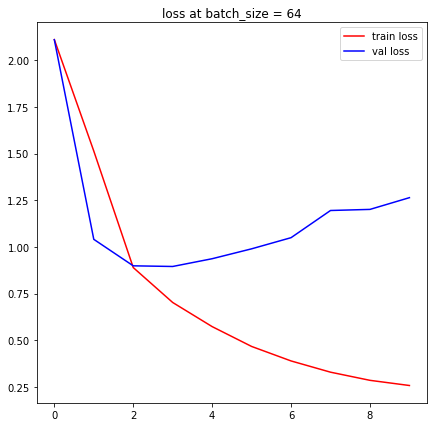

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(train_L_iters, c = "red", label = "train loss")
plt.plot(test_L_iters, c = "blue", label = "val loss")
plt.title("loss at batch_size = 64")
plt.legend(loc = "best")
plt.show()

# **Plot the Accuracy curve**

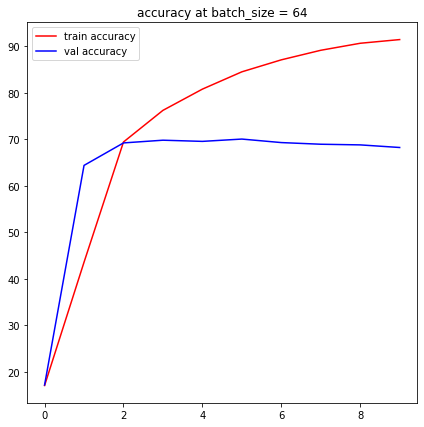

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(train_acc_iters, c = "red", label = "train accuracy")
plt.plot(test_acc_iters, c = "blue", label = "val accuracy")
plt.title("accuracy at batch_size = 64")
plt.legend(loc = "best")
plt.show()

# **Model Test**

In [ ]:
model = RNN(TEXT.vocab.vectors,300,300).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/bigdata/genreclassification.pt'))
model.eval()
tot_loss = 0
tot_correct = 0
for batch in test_iter:
  data, target = batch.review.to(device), batch.label.to(device)
  output = model(data)
  tot_loss += F.cross_entropy(output, target, reduction = 'sum').item()
  pred = output.argmax(dim = 1, keepdim = True)
  tot_correct += pred.eq(target.view_as(pred)).sum().item()
tot_loss /= len(test_iter.dataset)
accuracy = 100 * tot_correct / len(test_iter.dataset)
print("테스트 오차 : %5.2f | 테스트 정확도 : %5.2f" % (tot_loss,accuracy))

테스트 오차 :  0.89 | 테스트 정확도 : 69.96


# **MultiLabel Confusion Matrix**

# **Word Cloud**

In [12]:
pip install wordcloud

/content/drive/MyDrive/LabelTopWords/label 0.csv
{'movie': 43325, 'film': 31924, 'one': 14940, 'make': 14717, 'like': 14296, 'see': 14251, 'time': 13080, 'good': 12190, 'character': 11838, 'story': 11501, 'scene': 10778, 'get': 10423, 'well': 10061, 'great': 9862, 'really': 8284, 'watch': 8129, 'think': 7661, 'much': 7660, 'say': 6951, 'end': 6531, 'action': 6508, 'even': 6490, 'take': 6377, 'give': 6300, 'way': 6213, 'go': 6006, 'know': 5897, 'look': 5896, 'also': 5628, 'people': 5584, 'love': 5501, 'best': 5416, 'act': 5293, 'many': 5227, 'first': 5204, 'come': 5145, 'thing': 5005, 'long': 4881, 'effect': 4681, 'actor': 4523, 'hour': 4498, 'bad': 4497, 'feel': 4486, 'year': 4282, 'want': 4147, 'show': 4116, 'find': 4046, 'performance': 4016, 'seem': 4015, 'part': 3890, 'play': 3877, 'work': 3870, 'never': 3835, 'plot': 3775, 'fight': 3769, 'still': 3746, 'back': 3738, 'ever': 3573, 'big': 3557, 'little': 3500, 'battle': 3480, 'lot': 3438, 'man': 3387, 'life': 3312, 'role': 3296, 'ori

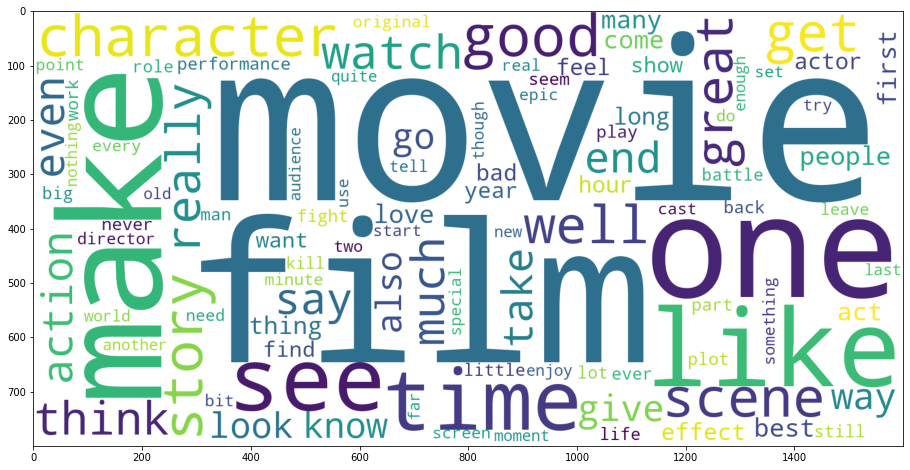

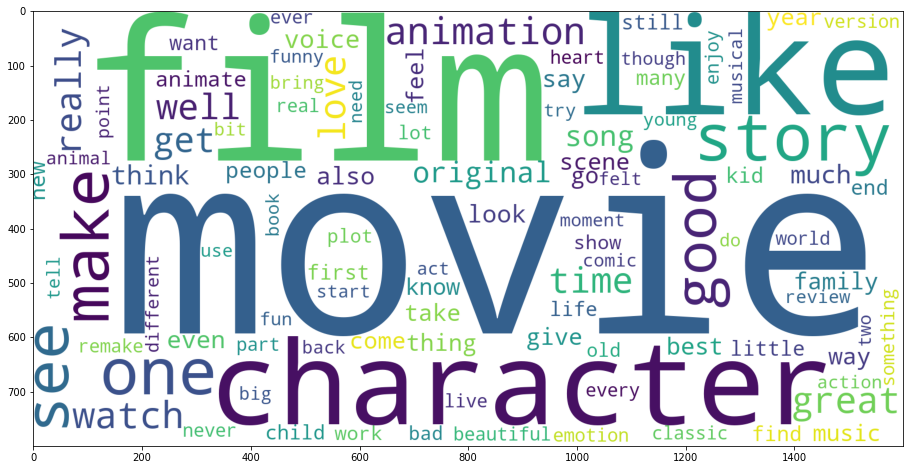

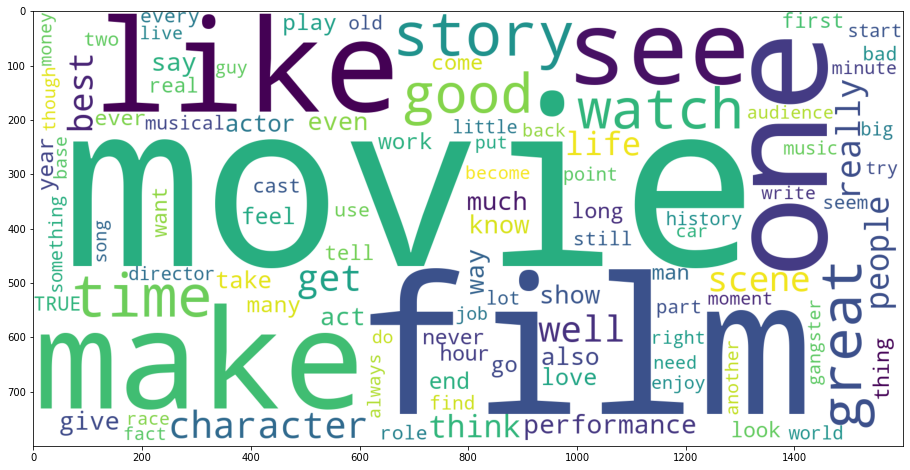

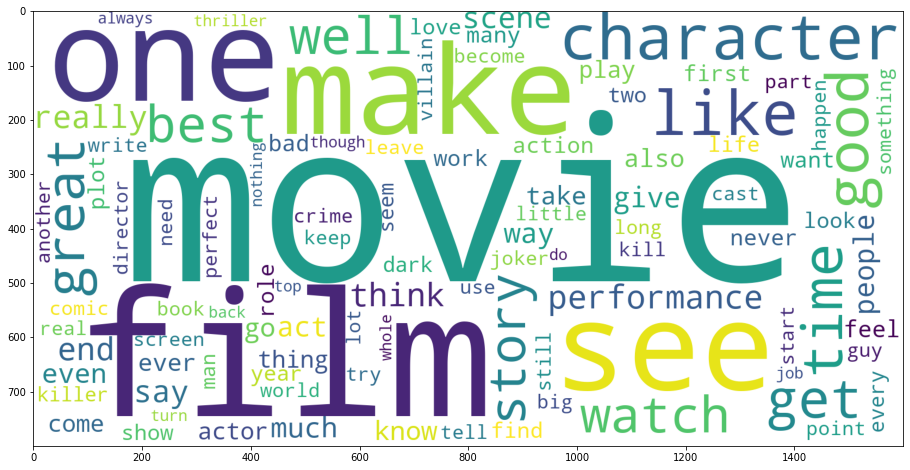

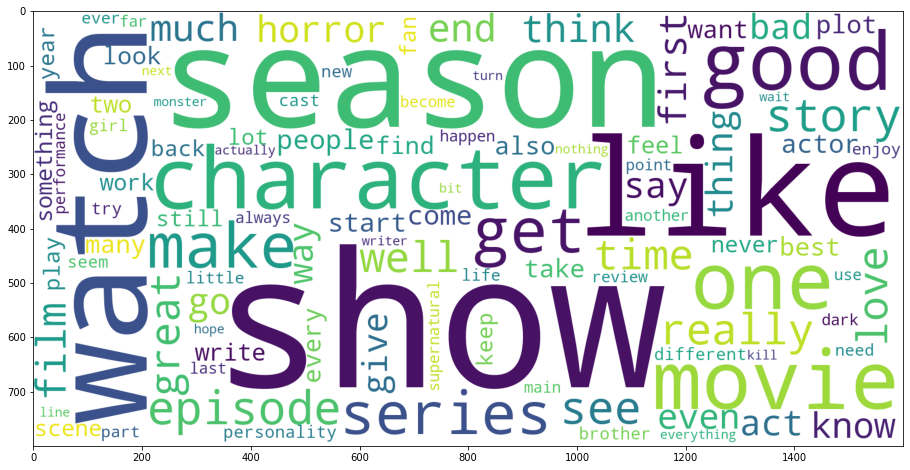

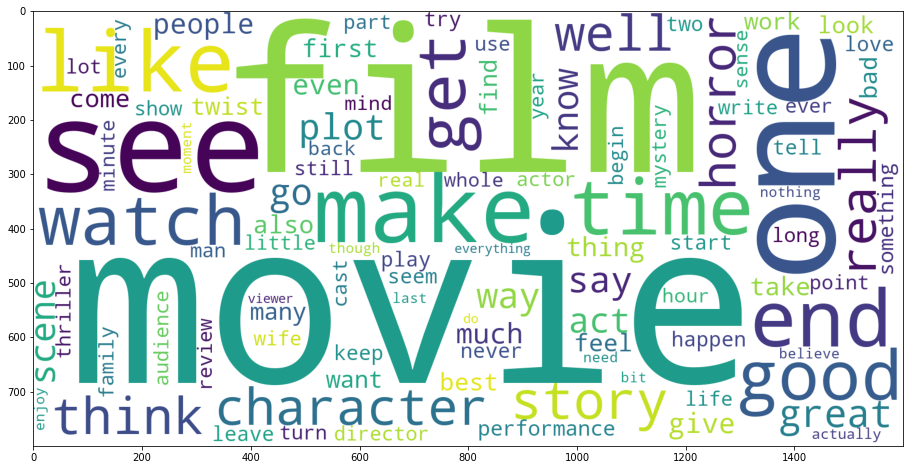

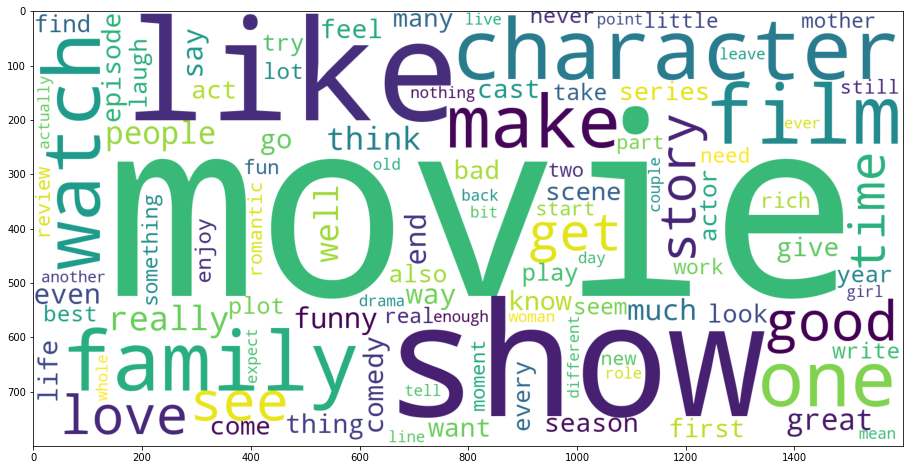

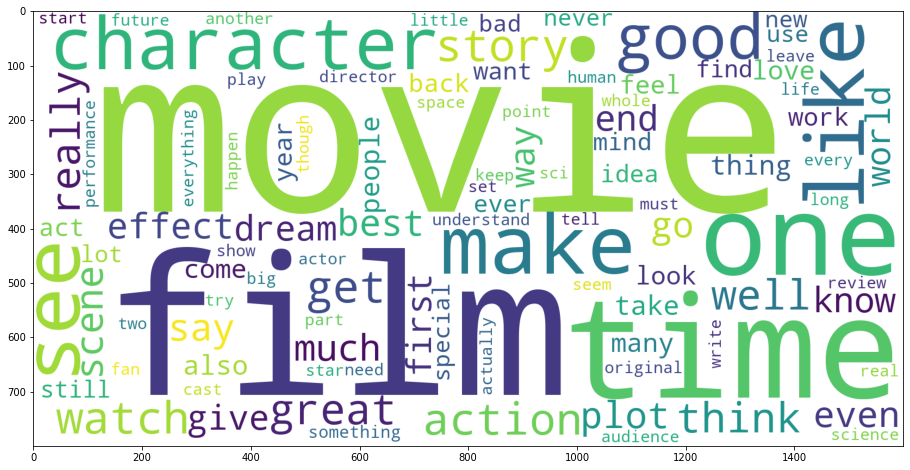

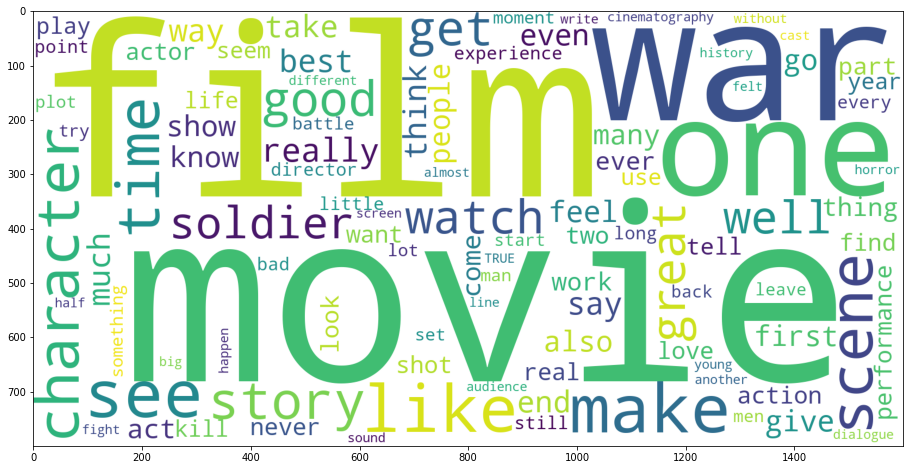

In [63]:
from wordcloud import WordCloud

for i in range(9):
  labeldic = {}
  labelfile = "/content/drive/MyDrive/LabelTopWords/label " + str(i) + ".csv"
  label = pd.read_csv(labelfile,index_col = 0)
  print(labelfile)
  for j in range(len(label)):
    labeldic[label.loc[j][0]] = int(label.loc[j][1])

  print(labeldic)
  wordCloud = WordCloud(background_color = "white", width=1600, height = 800).generate_from_frequencies(labeldic)
  plt.figure(figsize = (16,8), facecolor='w')
  plt.imshow(wordCloud)

 



